# Pricing with Rational Inattnetion: Partial Equilibrium with Endogenous Feedback

This notebook goes through a couple of examples for solving LQG Dynamic Rational Inattention models using the methods and the [solver](https://github.com/choongryulyang/dynamic_multivariate_RI) from [Afrouzi and Yang (2019)](http://www.afrouzi.com/dynamic_inattention.pdf) that was adapted for Julia by [Miguel Acosta](https://www.acostamiguel.com/home). To include the solver, execute:

In [8]:
include("Solve_RI_Dynamics.jl");

## Example 2: Pricing with Endogenous Feedback (MA Approximation)
### Background
Suppose now that there is general equilibirum feedback with the degree of strategic complementarity $\alpha$: $$p_{i,t}^*=(1-\alpha)q_t+\alpha p_t$$ where
\begin{align}
    \Delta q_t&=\rho \Delta q_{t-1}+u_t,\quad u_t\sim \mathcal{N}(0,\sigma_u^2) \\
    p_t&\equiv \int_0^1 p_{i,t}di
\end{align}
Note that now the state space representation for $p_{i,t}^*$ is no longer exogenous and is determined in the equilibrium. However, we know that this is a Guassian process and by Wold's theorem we can decompose it to its $MA(\infty)$ representation:
\begin{align}
    p_{i,t}^*=\Phi(L)u_t
\end{align}
where $\Phi(.)$ is a lag polynomial and $u_t$ is the shock to nominal demand. Here, we have basically guessed that the process for $p_{i,t}^*$ is determined uniquely by the history of monetary shocks which requires that rational inattention errors of firms are orthogonal (See [Afrouzi (2020)](www.afrouzi.com/strategic_inattetion.pdf)). Our objective is to find $\Phi(.)$. 

We cannot put $MA(\infty)$ processes in the computer and have to truncate them. However, we know that for stationary processes we can arbitrarily get close to the true process by truncating $MA(\infty)$ processes. Our problem here is that $p_{i,t}^*$ has a unit root and is not stationary. We can bypass this issue by re-writing the state space in the following way:
\begin{align}
    p_{i,t}^*=\phi(L)\tilde{u}_t,\quad \tilde{u}_t=(1-L)^{-1}u_t =\sum_{j=0}^\infty u_{t-j}
\end{align}
here $\tilde{u}_{t-j}$ is the unit root of the process and basically we have differenced out the unit root from the lag polynomial, and $\phi(L)=(1-L)\Phi(L)$. Notice that since the original process was difference stationary, differencing out the unit root means that $\phi(L)$ is now in $\ell_2$, and the process can now be approximated arbitrarily precisely with truncation. 

### Matrix Notation

For a length of truncation $L$, let $\vec{x}_t\equiv (\tilde{u}_t,\tilde{u}_{t-1},\dots,\tilde{u}_{t-(L+1)})\in\mathbb{R}^L$. Then, note that $p_{i,t}^*\approx \mathbf{H} '\vec{x}_{t}$ where $\mathbf{H}\in \mathbb{R}^L$ is the truncated matrix analog of the lag polynominal, and is endogenous to the problem. Our objective is to find the general equilibrium $\mathbf{H}$ along with the optimal information structure that it implies.

Moreover, note that $$q_t=\mathbf{H}_q'\vec{x}_t,\quad \mathbf{H}_q'=(1,\rho,\rho^2,\dots,\rho^{L-1})$$

We will solve for $\phi$ by iterating over the problem. In particular, in iteration $n\geq 1$, given the guess $\mathbf{H}_{(n-1)}$, we have the following state space representation for the firm's problem

\begin{align}
   \vec{x}_{t}&
    = \underset{\mathbf{A}}{\underbrace{\left[\begin{array}{ccccc}
        1 & 0 & \dots & 0 & 0\\
        1 & 0 & \dots & 0 & 0\\
        0 & 1 & \dots & 0 & 0\\
        \vdots & \vdots & \ddots & \vdots & \vdots\\
        0 & 0 & \dots & 1 & 0
        \end{array}\right]}}\, \vec{x}_{t-1} 
    + \underset{\mathbf{Q}}{\underbrace{\left[\begin{array}{c}
        \sigma_u\\
        0\\
        0\\
        \vdots\\
        0
        \end{array}\right]}}\, u_t, \\
        p_{i,t}^*&=\mathbf{H}_{(n-1)}'\vec{x}_{t}
\end{align}



Then we can solve the ratinoal inattention problem of all firms and get the new guess for $p_t^*$:
\begin{align}
    p_t^* & = (1-\alpha)q_t + \alpha p_t \\
      & = (1-\alpha)\sum_{j=0}^\infty \alpha^j q_t^{(j)},  \\
      q_{t}^{(j)}&\equiv \begin{cases}
q_{t} & j=0\\
\int_{0}^{1}\mathbb{E}_{i,t}[q_{t}^{(j-1)}]di & j\geq1
\end{cases}
\end{align}

where $q_t^{(j)}$ is the $j$'th order belief of firms, on average, of $q_t$. Now, we need to write these higher order beliefs in terms of the state vector. Suppose, for a given $j$, there exists $\mathbf{X}_j\in \mathbb{R}^{L\times L}$ such that 
$$ q_t^{(j)} = \mathbf{H}_q'\mathbf{X}_j \vec{x}_t $$
This clearly holds for $j=0$ with $\mathbf{X}_0=\mathbf{I}$. 

Now, note that

\begin{align}
    q_{t}^{(j+1)} &= \int_{0}^{1}\mathbb{E}_{i,t}[q_{t}^{(j)}]di \\
                  &= \mathbf{H}_{q}'\mathbf{X}_{j}\int_{0}^{1}\mathbb{E}_{i,t}[\vec{x}_{t}]di \\
                  &= \mathbf{H}_{q}'\mathbf{X}_{j}\sum_{j=0}^{\infty}[(\mathbf{I}-\mathbf{K}_{(n)}\mathbf{Y}'_{(n)})\mathbf{A}]^{j}\mathbf{K}_{(n)}\mathbf{Y}'_{(n)}\vec{x}_{t-j} \\
                  &\approx\underset{\equiv\mathbf{X}_{(n)}}{\mathbf{H}_{q}'\mathbf{X}_{j}\underbrace{\left[\sum_{j=0}^{\infty}[(\mathbf{I}-\mathbf{K}_{(n)}\mathbf{Y}'_{(n)})\mathbf{A}]^{j}\mathbf{K}_{(n)}\mathbf{Y}'_{(n)}\mathbf{M}'^{j}\right]}}\vec{x}_{t}=\mathbf{H}_{q}'\mathbf{X}_{j}\mathbf{X}_{(n)}\vec{x}_{t}
\end{align}

where the $(n)$ subscripts refer to the solution of the RI problem in the $(n)$'th iteration. Note that this implies
$$\mathbf{X}_{j}=\mathbf{X}_{(n)}^j,\forall j\geq 0 \Rightarrow q_t^{(j)}=\mathbf{X}_{(n)}^{j}\vec{x}_t $$

This gives us an updated guess for $\mathbf{H}$:
\begin{align}
    p_t^*&=(1-\alpha)\mathbf{H}_q'\underset{\equiv \mathbf{X}_{p,(n)}}{\underbrace{\left[\sum_{j=0}^\infty \alpha^j \mathbf{X}_{(n)}^j\right]}} \vec{x}_t \\
        &\Rightarrow \mathbf{H}_{(n)} =  (1-\alpha)\mathbf{X}_{p,(n)}'\mathbf{H}_q
\end{align}
We iterate until convergence of $\mathbf{H}_{(n)}$.

### Setting up the problem

In [5]:
ρ   = 0.6;        #persistence of money growth
σ_u = 0.1;        #std. deviation of shocks to money growth
α   = 0.8;        #degree of strategic complementarity
L   = 60;         #length of truncation
Hq  = ρ.^(0:L-1); #state-space rep. of Δq 

## specifying the primitives of the drip
ω   = 0.2;       
β   = 0.99;  
A   = [1 zeros(1,L-2) 0; Matrix(I,L-1,L-1) zeros(L-1,1)];
Q   = [σ_u; zeros(L-1,1)];

Let us now define a function that solves the GE problem and returns the solution in a `drip` structure:

In [6]:
function ge_drip(ω,β,A,Q,       #primitives of drip except for H because H is endogenous
                 α,             #strategic complementarity
                 Hq,            #state space rep. of Δq
                 L;             #length of truncation
                 H0    = Hq,    #optional: initial guess for H (Hq is the true solution when α=0)
                 maxit = 200,   #optional: max number of iterations for GE code 
                 tol   = 1e-12)  #optional: tolerance for iterations
    
    # set primitives
    err   = 1;  
    iter  = 0;
    M     = [zeros(1,L-1) 0; Matrix(I,L-1,L-1) zeros(L-1,1)];
    eye   = Matrix(I,L,L);
    # iterate on GE
    while (err > tol) & (iter < maxit)
            if iter == 0 
                global ge  = Solve_RI_Dynamics(ω,β,A,Q,H0); 
            else 
                global ge  = Solve_RI_Dynamics(ω,β,A,Q,H0;Ω0 = ge.Ω ,Σ0 = ge.Σ_1);
            end
            K = real.(ge.K)
            Y = real.(ge.Y)

             if maximum(abs.(imag.(ge.K))) > 1e-6 || maximum(abs.(imag.(ge.Y))) > 1e-6
                 println("Complex components are large")
             end

            XFUN(jj) = ((eye-K*Y')*ge.A)^jj * (K*Y') * (M')^jj
            X = infinitesum(XFUN; maxit=L, start = 0);  #E[x⃗]=X×x⃗

            XpFUN(jj) = α^jj * X^(jj)
            Xp = infinitesum(XpFUN; maxit=L, start = 0);

            H1 = (1-α)*Xp'*Hq;
            err= norm(H1-H0,2);
            H0 = H1;

            if iter == maxit
                print("GE loop hit maxit -- no convergence\n")
            end
            iter += 1;
            println("Iteration $iter. Difference: $err")
    end
    return(ge)
end

@time ge = ge_drip(ω,β,A,Q,α,Hq,L);

Iteration 1. Difference: 0.6511902977705418
Iteration 2. Difference: 1.3012860452723171e-8
Iteration 3. Difference: 0.12339273124391253
Iteration 4. Difference: 7.129632700428119e-10
Iteration 5. Difference: 0.03811097596248644
Iteration 6. Difference: 7.919396346502843e-10
Iteration 7. Difference: 0.013656029555245955
Iteration 8. Difference: 8.95369648985233e-10
Iteration 9. Difference: 0.0051939329940783995
Iteration 10. Difference: 5.506584684546144e-10
Iteration 11. Difference: 0.002030634393804909
Iteration 12. Difference: 4.746200826542839e-10
Iteration 13. Difference: 0.0008048895753891267
Iteration 14. Difference: 4.744822143508575e-10
Iteration 15. Difference: 0.000321351130491384
Iteration 16. Difference: 4.871453869556282e-10
Iteration 17. Difference: 0.0001288060686530801
Iteration 18. Difference: 7.860875771178919e-10
Iteration 19. Difference: 5.1740601424655604e-5
Iteration 20. Difference: 4.835356569097241e-10
Iteration 21. Difference: 2.080904763735376e-5
Iteration 22.

Iteration 173. Difference: 8.690554185100042e-9
Iteration 174. Difference: 8.53193489190863e-9
Iteration 175. Difference: 8.377060295966545e-9
Iteration 176. Difference: 8.227753142948733e-9
Iteration 177. Difference: 8.086202029074459e-9
Iteration 178. Difference: 7.939205291632492e-9
Iteration 179. Difference: 7.791736326586038e-9
Iteration 180. Difference: 7.649375768413685e-9
Iteration 181. Difference: 7.510847255614232e-9
Iteration 182. Difference: 7.376838033178666e-9
Iteration 183. Difference: 7.243375683203752e-9
Iteration 184. Difference: 7.111259576645613e-9
Iteration 185. Difference: 6.987384687747202e-9
Iteration 186. Difference: 6.865166765224982e-9
Iteration 187. Difference: 6.742069180900468e-9
Iteration 188. Difference: 6.622782318248988e-9
Iteration 189. Difference: 6.500385732058273e-9
Iteration 190. Difference: 6.381114182768569e-9
Iteration 191. Difference: 6.263028448561675e-9
Iteration 192. Difference: 6.150033652019423e-9
Iteration 193. Difference: 6.041100120093

Get IRFs:

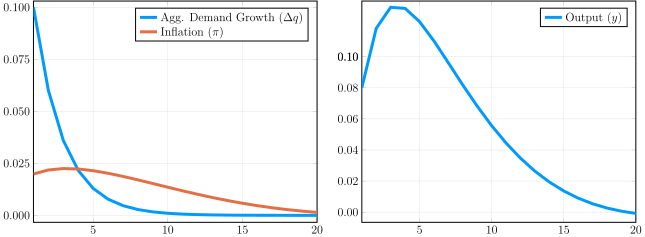

In [7]:
using Plots, LaTeXStrings; pgfplots();
T      = L;
geirfs = dripirfs(ge,T);

M  = [zeros(1,T-1) 0; Matrix(I,T-1,T-1) zeros(T-1,1)];
dq = diagm(Hq)*geirfs.x[1,1,:];
Pi = (I-M)*geirfs.a[1,1,:];
y  = inv(I-M)*(dq-Pi);

p1 = plot(1:T,[dq,Pi],
     label = [L"Agg. Demand Growth ($\Delta q$)" L"Inflation ($\pi$)"]);

p2 = plot(1:T,y,
     label  = L"Output ($y$)");

display(plot(p1,p2,
    layout     = (1,2),
    xlim       = (1,20),
    lw         = 3,
    legend     = :topright,
    legendfont = font(12),
    tickfont   = font(12),
    size       = (900,370),
    framestyle = :box));